# LSTM-时间序列预测

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

C:\Users\13936\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\13936\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  # Remove the CWD from sys.path while we load stuff.


In [2]:
warnings.filterwarnings('ignore')

In [3]:
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['axes.grid'] = False

In [4]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  使用CPU(默认情况下使用GPU(如果你已经安装了GPU版本))
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

In [5]:
# 下载数据集
# 数据集使用由马克斯·普朗克生物地球化学研究所记录的[天气时间序列数据集。
# 该数据集包含14个不同的特征，例如气温，大气压力和湿度。
# 从2003年开始，每10分钟收集一次。为了提高效率，您将仅使用2009年至2016年之间收集的数据。
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [6]:
df = pd.read_csv(csv_path)
df.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


## 一、单变量时间序列预测

In [7]:
# 首先，将仅使用一个特征（温度）训练模型，并在将来使用该模型为该值做出预测。
# 首先，从数据集中提取温度。
data_T = df['T (degC)']
data_T.index = df['Date Time']
data_T.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

In [8]:
train_split = 300000

In [9]:
data_T = data_T.values

In [10]:
data_T_mean = data_T[:train_split].mean()
data_T_std = data_T[:train_split].std()

In [11]:
data_T = (data_T - data_T_mean) / data_T_std

In [12]:
print(data_T.shape)

(420551,)


In [ ]:
# 如上所示，每10分钟记录一次观察值。 
# 这意味着在一个小时内，将有6个观测值。
# 同样，一天将包含144（6x24）次观察。
# 给定一个特定的时间，假设要预测未来6小时的温度。
# 为了做出此预测，选择使用5天的观察时间。 
# 因此，您将创建一个包含连续720（5x144）个观测值的窗口以训练模型。
# 下面的函数返回上述时间窗以供模型训练。 
# 参数history_size是过去信息窗口的大小。 
# target_size是模型将来需要学习预测的范围。

In [13]:
def get_data(data, history_size, target_size):
    datas = []
    labels = []
    for i in tqdm(range(len(data) - history_size)):
        datas.append(np.reshape(data[i:i+history_size], (history_size, 1)))
        labels.append(data[i+history_size+target_size])
    return np.array(datas), np.array(labels)

In [14]:
# 现在让我们为单变量模型创建数据。
# 对于第1部分，将为模型提供连续的20个记录的温度观测值，并且需要学习预测下一个时间步长的温度。
history_size = 20
target_size = 0
x_train, y_train = get_data(data_T[:train_split], history_size, target_size)
x_valid, y_valid = get_data(data_T[train_split:], history_size, target_size)

In [4]:
tf.random.set_seed(1996)

In [15]:
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
print(x_train[0])
print(y_train[0])

(299980, 20, 1) (299980,) (120531, 20, 1) (120531,)
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]
-2.1041848598100876


In [16]:
batch_size = 256
buffer_size = 10000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

valid_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid_data = valid_data.batch(batch_size).repeat()

In [17]:
simple_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.summary()

simple_lstm_model.compile(optimizer='adam', loss='mae')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 这里的步数（step）是200和50， 是为了减少训练时间，正确的步数应该是下面的这样
# train_step = len(y_train) / batch_size
# valid_step = len(y_valid) / batch_size

epoch = 20
train_step = 200
valid_step = 50

simple_lstm_model.fit(train_data, epochs = epoch,
                      steps_per_epoch = train_step,
                      validation_data = valid_data,
                      validation_steps = valid_step)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 3s 13ms/step - loss: 0.4561 - val_loss: 0.1116
Epoch 2/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0921 - val_loss: 0.0311
Epoch 3/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0428 - val_loss: 0.0256
Epoch 4/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0386 - val_loss: 0.0224
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0260 - val_loss: 0.0208
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0285 - val_loss: 0.0201
Epoch 7/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0262 - val_loss: 0.0194
Epoch 8/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0247 - val_loss: 0.0182
Epoch 9/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0241 - val_loss: 0.0176
Epoch 10/20
200/200 [==============================] - 1

In [19]:
def create_time_steps(length):
    return list(range(-length, 0))

In [20]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

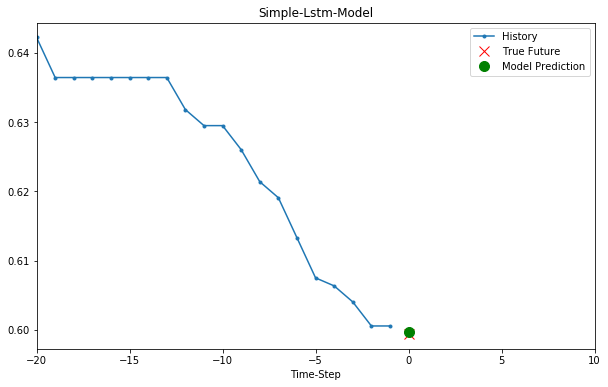

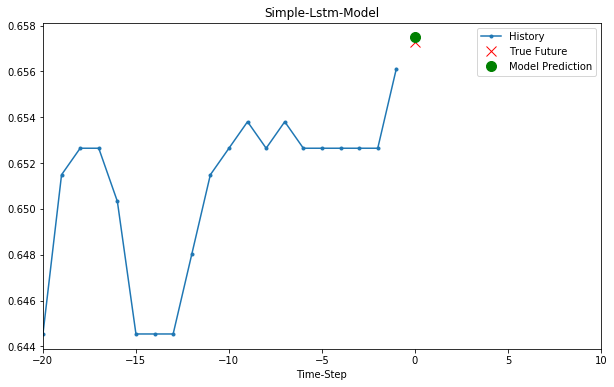

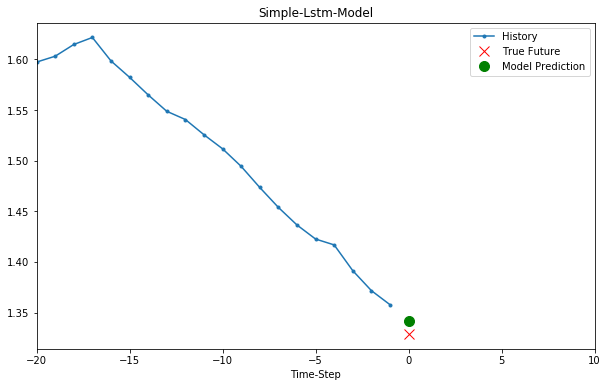

In [21]:
for x, y in valid_data.take(3):
    plt.figure(figsize=(10, 6), facecolor='w')
    show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], target_size, 'Simple-Lstm-Model')

## 二、多变量时间序列预测

In [22]:
# 原始数据集包含十四个特征。
# 为简单起见，仅考虑原始的十四个中的三个。
# 使用的功能是气温，大气压力和空气密度。
# 要使用更多功能，请将其名称添加到此列表中。
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [23]:
features = df[features_considered]
features.index = df['Date Time']
features.head(2)

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F584697198>,
      dtype=object)

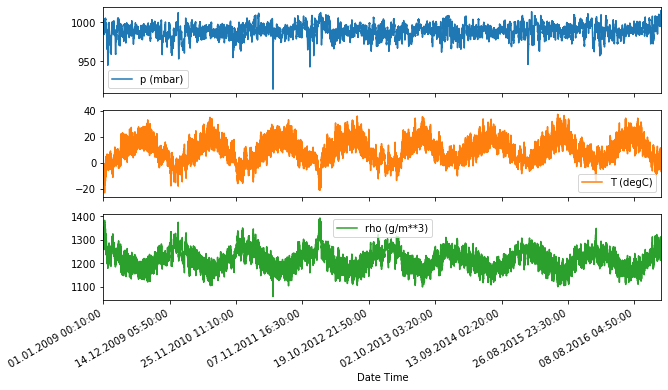

In [24]:
features.plot(subplots=True)

In [25]:
dataset = features.values
data_mean = dataset[:train_split].mean(axis=0)
data_std = dataset[:train_split].std(axis=0)

In [26]:
dataset = (dataset - data_mean) / data_std

In [27]:
print(dataset.shape)

(420551, 3)


### 单步的模型

In [30]:
# 在一步设置中，模型将根据提供的某些历史记录来学习预测未来的单个点。
# 下面的函数执行与下面相同的加窗任务，但是，此处它根据给定的步长对过去的观察进行采样。
def get_multivariate_data(data, target, history_size, target_size, step, multy_step):
    datas = []
    labels = []
    for i in tqdm(range(len(data) - history_size - target_size)):
        idx = np.arange(i, i + history_size, step)
        datas.append(np.reshape(data[idx], (history_size // step, 3)))
        if multy_step:
            labels.append(target[i+history_size:i+history_size+target_size])
        else:
            labels.append(target[i+history_size+target_size])
    return np.array(datas), np.array(labels)

In [31]:
# 向网络显示最近五（5）天的数据，即每小时采样720个观测值。
# 每隔一小时进行一次采样，因为预计60分钟内不会发生剧烈变化。
# 因此，120次观察代表最近五天的历史。
# 对于单步预测模型，数据点的标签是未来12小时的温度。 
# 为了为此创建标签，使用72（12 * 6）次观察后的温度。
history_size = 720
target_size = 72
step = 6
train_dataset = dataset[:train_split]
valid_dataset = dataset[train_split:]
x_train_single, y_train_single = get_multivariate_data(train_dataset, train_dataset[:, 1], history_size, target_size, step, False)
x_valid_single, y_valid_single = get_multivariate_data(valid_dataset, valid_dataset[:, 1], history_size, target_size, step, False)

In [32]:
print(x_train_single.shape, y_train_single.shape, x_valid_single.shape, y_valid_single.shape)

(299208, 120, 3) (299208,) (119759, 120, 3) (119759,)


In [33]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(buffer_size).batch(batch_size).repeat()

valid_data_single = tf.data.Dataset.from_tensor_slices((x_valid_single, y_valid_single))
valid_data_single = valid_data_single.batch(batch_size).repeat()

In [37]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=(x_train_single.shape[-2:])))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.summary()

single_step_model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss='mae')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4608      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [38]:
for x, y in valid_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [39]:
# 这里的步数（step）是200和50， 是为了减少训练时间，正确的步数应该是下面的这样
# train_step = len(y_train_single) / batch_size
# valid_step = len(y_valid_single) / batch_size

epoch = 10
train_step = 200
valid_step = 50

single_step_history = single_step_model.fit(train_data_single, epochs = epoch,
                      steps_per_epoch = train_step,
                      validation_data = valid_data_single,
                      validation_steps = valid_step)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 17s 87ms/step - loss: 0.3146 - val_loss: 0.2626
Epoch 2/10
200/200 [==============================] - 20s 99ms/step - loss: 0.2626 - val_loss: 0.2430
Epoch 3/10
200/200 [==============================] - 24s 122ms/step - loss: 0.2615 - val_loss: 0.2435
Epoch 4/10
200/200 [==============================] - 30s 148ms/step - loss: 0.2584 - val_loss: 0.2412
Epoch 5/10
200/200 [==============================] - 40s 199ms/step - loss: 0.2263 - val_loss: 0.2349
Epoch 6/10
200/200 [==============================] - 48s 242ms/step - loss: 0.2411 - val_loss: 0.2490
Epoch 7/10
200/200 [==============================] - 51s 254ms/step - loss: 0.2384 - val_loss: 0.2594
Epoch 8/10
200/200 [==============================] - 49s 243ms/step - loss: 0.2431 - val_loss: 0.2382
Epoch 9/10
200/200 [==============================] - 48s 242ms/step - loss: 0.2418 - val_loss: 0.2424
Epoch 10/10
200/200 [===========

In [40]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(10, 6), facecolor='w')

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

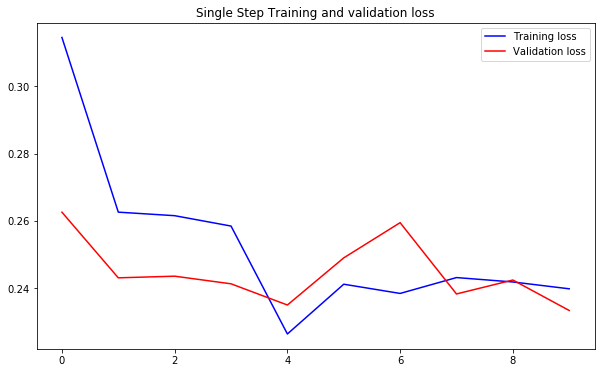

In [41]:
plot_train_history(single_step_history, 'Single Step Training and validation loss')

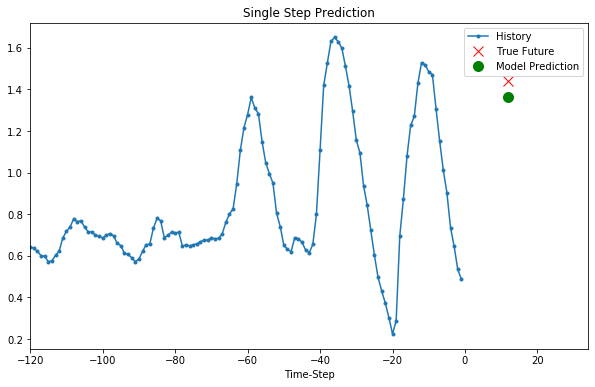

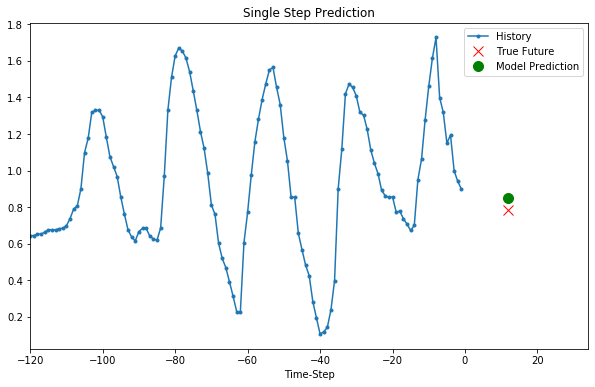

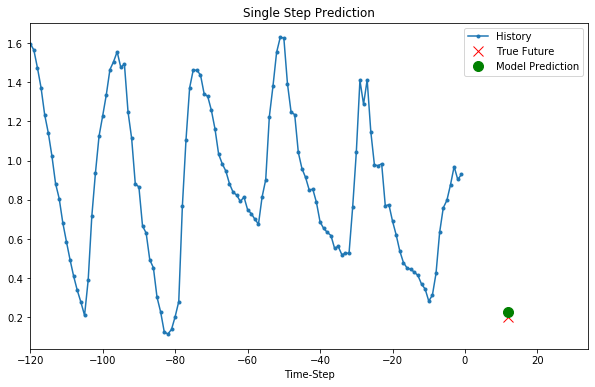

In [42]:
for x, y in valid_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

## 多步的模型

In [ ]:
# 在多步骤预测模型中，给定过去的历史，该模型需要学习预测一系列未来值。
# 因此，与仅预测单个未来点的单步模型不同，多步模型预测未来的序列。
# 对于多步骤模型，训练数据再次包括每小时采样的过去五天的记录。 
# 但是，这里的模型需要学习预测接下来12小时的温度。
# 由于每10分钟进行一次反驳，因此输出为72个预测。
# 对于此任务，需要相应地准备数据集，因此第一步只是再次创建它，但使用不同的目标窗口。

In [43]:
histort_size = 720
future_target = 72
step = 6
x_train_multi, y_train_multi = get_multivariate_data(dataset[:train_split], dataset[:train_split][:, 1], history_size, future_target, step, True)
x_valid_multi, y_valid_multi = get_multivariate_data(dataset[train_split:], dataset[train_split:][:, 1], histort_size, future_target, step, True)

In [44]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [45]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

valid_data_multi = tf.data.Dataset.from_tensor_slices((x_valid_multi, y_valid_multi))
valid_data_multi = valid_data_multi.batch(batch_size).repeat()

In [46]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/step, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/step, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

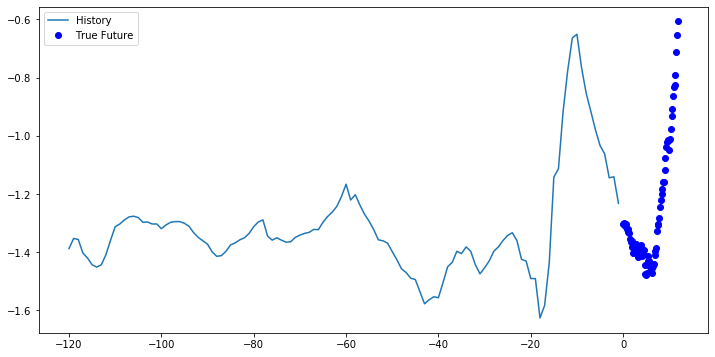

In [47]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [53]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, 
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1), loss='mae')

In [54]:
for x, y in valid_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(256, 72)


In [55]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=epoch,
                                          steps_per_epoch=200,
                                          validation_data=valid_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 140s 701ms/step - loss: 0.4658 - val_loss: 0.3051
Epoch 2/10
200/200 [==============================] - 143s 714ms/step - loss: 0.3122 - val_loss: 0.2625
Epoch 3/10
200/200 [==============================] - 141s 705ms/step - loss: 0.2806 - val_loss: 0.2287
Epoch 4/10
200/200 [==============================] - 141s 703ms/step - loss: 0.2324 - val_loss: 0.2108
Epoch 5/10
200/200 [==============================] - 140s 702ms/step - loss: 0.1988 - val_loss: 0.2083
Epoch 6/10
200/200 [==============================] - 141s 704ms/step - loss: 0.2097 - val_loss: 0.2148
Epoch 7/10
200/200 [==============================] - 139s 693ms/step - loss: 0.2042 - val_loss: 0.2090
Epoch 8/10
200/200 [==============================] - 139s 694ms/step - loss: 0.2031 - val_loss: 0.1904
Epoch 9/10
200/200 [==============================] - 145s 726ms/step - loss: 0.2039 - val_loss: 0.1960
Epoch 10/10
200/200 [

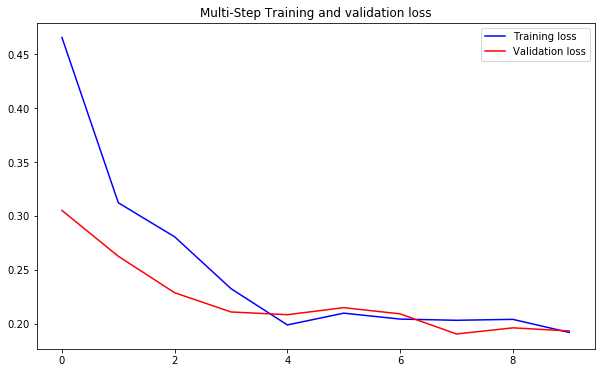

In [56]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

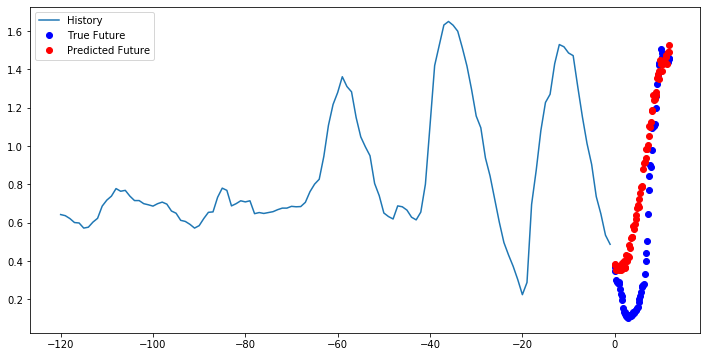

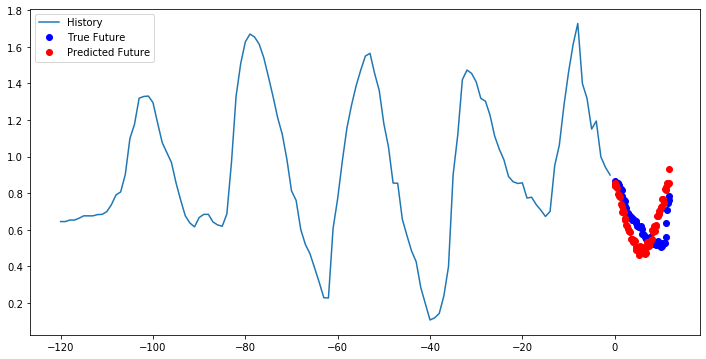

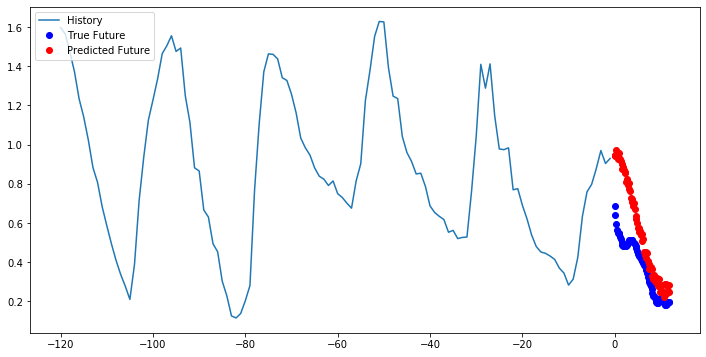

In [57]:
for x, y in valid_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])